<a href="https://colab.research.google.com/github/muhhanifra/Sign-Language-Recognition-modelling/blob/main/SL_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
import pandas as pd
import json
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTMCell
import time

In [ ]:
#------------access drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/SL-modeling-v1

Mounted at /content/drive
/content/drive/My Drive/SL-modeling-v1


In [ ]:
def load_and_split(df_dataset, val_size = 0.2, shuffle = True, print_progress = False):
  if shuffle:
    df_dataset = sklearn.utils.shuffle(df_dataset)

  hm_paths = list(df_dataset['data_path'].values)
  X_list = []
  for i, hm_path in enumerate(hm_paths):
    hm_path = '/'.join(hm_path.split('\\'))
    X_list.append(np.load(hm_path, allow_pickle=True))
    if print_progress:
      if i%10 == 0:
        print('{} loaded, iter {}'.format(hm_path, i))

  y = np.array([i for i in df_dataset['labels'].values])

  m = len(X_list)

  X_list_val = X_list[int(m*(1 - val_size)):]
  y_val = y[int(m*(1 - val_size)):, :]

  X_list = X_list[:int(m*(1 - val_size))]
  y = y[:int(m*(1 - val_size)), :]

  print('training set size:', len(X_list))
  print('validation set size', len(X_list_val))

  return X_list, y, X_list_val, y_val

def get_mini_batches(X_load_chunk,y_chunk , batch_size = 4):
  X_batches = []
  y_batches = []
  for i in range(np.ceil(X_load_chunk.shape[0]/batch_size).astype(int)):
    if (X_load_chunk.shape[0] - (i*batch_size)) < batch_size:
      X_batches.append(X_load_chunk[i*batch_size:,:,:,:])
      y_batches.append(y_chunk[i*batch_size:,:])
    else:
      print(X_load_chunk.shape)
      X_batches.append(X_load_chunk[i*batch_size:(i + 1)*batch_size,:,:,:])
      y_batches.append(y_chunk[i*batch_size:(i+1)*batch_size, :])
  return X_batches, y_batches

def return_batch_matrices(X_list_batch, y_list_batch = None, batch_size = None, n_frame = 151):
  X_load_chunk = []
  print('unzipping chunks...')
  for idx, x_zip in enumerate(X_list_batch):
    x_array = x_zip['hm']
    if x_array.shape[0] == n_frame:
      X_load_chunk.append(x_array)
    else:
      y_list_batch = np.concatenate((y_list_batch[:idx, :], y_list_batch[idx+1:, :]), axis = 0)
      print('skipped corrupted file . . .')
  X_load_chunk = np.array(X_load_chunk)
  print(X_load_chunk.shape)
  if batch_size:
    X_batches,y_batches = get_mini_batches(X_load_chunk, y_list_batch, batch_size)
    return X_batches,y_batches
  else:
    return X_load_chunk

def predict_batch(model, X_list, load_chunks = 50):
  y_predict_class = []
  for chunk_idx in range(np.ceil(len(X_list)/load_chunks).astype(int)):
    if (len(X_list) - (chunk_idx*load_chunks)) < load_chunks:
      X_list_batch = X_list[chunk_idx*load_chunks:]
    else:
      X_list_batch = X_list[chunk_idx*load_chunks:(chunk_idx + 1)*load_chunks]
    
    X_list_batch = return_batch_matrices(X_list_batch)
    
    print('predict on validation...')
    y_predict = model.predict(X_list_batch, batch_size=1)
    if len(y_predict_class) == 0:
      y_predict_class = np.argmax(y_predict , axis = 2)
    else:
      y_predict_class = np.concat((y_predict_class, np.argmax(y_predict , axis = 2)), axis = 0)

    return y_predict_class

def evaluate_model(model, X_list_val, y_val, load_chunks_val = 50): #quest ! ! !
  y_predict_class = []
  for chunk_idx in range(np.ceil(len(X_list_val)/load_chunks_val).astype(int)):
    if (len(X_list_val) - (chunk_idx*load_chunks_val)) < load_chunks_val:
      X_list_batch_val = X_list_val[chunk_idx*load_chunks_val:]
      y_list_batch_val = y_val[chunk_idx*load_chunks_val:, :]
    else:
      X_list_batch_val = X_list_val[chunk_idx*load_chunks_val:(chunk_idx + 1)*load_chunks_val]
      y_list_batch_val = y_val[chunk_idx*load_chunks_val:(chunk_idx + 1)*load_chunks_val,:]
    
    X_list_batch_val = return_batch_matrices(X_list_batch_val)
    
    print('predict on validation...')
    y_predict = model.predict(X_list_batch_val, batch_size=1)
    if len(y_predict_class) == 0:
      y_predict_class = np.argmax(y_predict , axis = 2)
    else:
      y_predict_class = np.concat((y_predict_class, np.argmax(y_predict , axis = 2)), axis = 0)

  metrics = []
  for k in range(y_predict_class.shape[0]):
    metric = f1_score(y_val[k,:], y_predict_class[k, :], average ='macro')
    metrics.append(metric)

  f1_total_average = np.mean(metrics)    

  return f1_total_average,y_predict_class

def evaluate_model_by_plot(model, X_list_val, y_val, load_chunks_val = 50):
  pass

In [ ]:
#-----------load input path and labels
json_path = '/content/drive/My Drive/SL-modeling-v1/data/heatmaps_and_labels.json'
with open(json_path, 'r') as json_file:
  data = json.load(json_file)
  
df_dataset = pd.DataFrame({'data_path':data['npz_paths'], #heatmaps path
                           'labels': data['label_vec']} #labels (m x number_of_timestep)
                          )
num_class = len(np.unique(data['label_vec']))
num_class

10

In [ ]:
X_list, y, X_list_val, y_val = load_and_split(df_dataset, print_progress=True, val_size = 0.1)

data/heatmaps/terimakasih_46.npz loaded, iter 0
data/heatmaps/samasama_37.npz loaded, iter 10
data/heatmaps/alhamdulillah_7.npz loaded, iter 20
data/heatmaps/apakabar_32.npz loaded, iter 30
data/heatmaps/terimakasih_40.npz loaded, iter 40
data/heatmaps/saya_21.npz loaded, iter 50
data/heatmaps/hai_37.npz loaded, iter 60
data/heatmaps/terimakasih_5.npz loaded, iter 70
data/heatmaps/baik_48.npz loaded, iter 80
data/heatmaps/baik_15.npz loaded, iter 90
data/heatmaps/apakabar_1.npz loaded, iter 100
data/heatmaps/hai_2.npz loaded, iter 110
data/heatmaps/terimakasih_21.npz loaded, iter 120
data/heatmaps/hallo_39.npz loaded, iter 130
data/heatmaps/dia_33.npz loaded, iter 140
data/heatmaps/baik_46.npz loaded, iter 150
data/heatmaps/apakabar_46.npz loaded, iter 160
data/heatmaps/hai_46.npz loaded, iter 170
data/heatmaps/alhamdulillah_24.npz loaded, iter 180
data/heatmaps/baik_7.npz loaded, iter 190
data/heatmaps/dia_12.npz loaded, iter 200
data/heatmaps/samasama_43.npz loaded, iter 210
data/hea

In [ ]:
def create_pureLSTM_model(num_class,frames = 151):
  
  input_layer = layers.Input(shape = (frames, 51, 69, 22))
  x = layers.MaxPool3D(pool_size=(1, 2, 2), name = 'maxpool_1')(input_layer)

  #fully connected by conv3d op
  t_shape = x.shape.as_list()
  x = layers.Conv3D(256, (1, t_shape[2], t_shape[3]), activation='relu', name = 'dense_layer_1')(x)
  x = layers.LayerNormalization()(x)

  t_shape = x.shape.as_list()
  x = layers.Reshape(target_shape= (frames, t_shape[2]*t_shape[3]*t_shape[4]))(x)

  #processing sequence
  x = layers.LSTM(256, return_sequences= True, name = 'lstm-1')(x)
  x = layers.LayerNormalization()(x)
  x = layers.LSTM(256, return_sequences= True, name = 'lstm-2')(x)
  x = layers.LayerNormalization()(x)

  x = layers.Dense(num_class,activation='softmax')(x)
  model = models.Model(input_layer, x)
  return model

In [ ]:
model = create_pureLSTM_model(num_class)
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0005)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy')

In [ ]:
prediction = predict_batch(model, X_list_val, load_chunks = 50) #sanity check

unzipping chunks...
(46, 151, 51, 69, 22)
predict on validation...


In [ ]:
f1_acc, prediction = evaluate_model(model, X_list_val, y_val, load_chunks_val = 50) #sanity check

unzipping chunks...
(46, 151, 51, 69, 22)
predict on validation...


In [ ]:
f1_acc

0.02541908547804234

In [ ]:
#-------------------------TRAIN LOOP-------------------------------------------
#one epoch
load_chunks = 50
EPOCHS = 20
BATCH_SIZE = 8
history_dict = {'loss': [],'acc': []}
f1_acc_best = -1*float('inf')
for i in range(EPOCHS):
  for chunk_idx in range(np.ceil(len(X_list)/load_chunks).astype(int)):

    if (len(X_list) - (chunk_idx*load_chunks)) < load_chunks:
      X_list_batch = X_list[chunk_idx*load_chunks:]
      y_list_batch = y[chunk_idx*load_chunks:, :]
    else:
      X_list_batch = X_list[chunk_idx*load_chunks:(chunk_idx + 1)*load_chunks]
      y_list_batch = y[chunk_idx*load_chunks:(chunk_idx + 1)*load_chunks, :]

    X_batches, y_batches = return_batch_matrices(X_list_batch, y_list_batch, batch_size = 8)
    print('{}-th chunk'.format(chunk_idx+1))
    for j in range(len(y_batches)):
      #print('x:',X_batch.shape,'y:', y_batches[i].shape) #debugging
      history = model.train_on_batch(X_batches[j],y_batches[j],reset_metrics= False)

      history_dict['loss'].append(history)
      #history_dict['acc'].append(history[1])
      print('loss: {}, on epoch: {}, step: {}'.format(history, i+1, j+1, end ="\r"))
      
  print('evaluate epoch {} on validation. . .'.format(i+1))
  f1_acc, _ = evaluate_model(model, X_list_val, y_val)
  print('====validation acc: {}===='.format(f1_acc))
  if f1_acc > f1_acc_best:
    print('f1 improved from {} to {}, overwriting best_model.h5'.format(f1_acc_best,f1_acc))
    f1_acc_best = f1_acc
    model.save('best_model.h5')
  else:
    print('no improvement on f1 score, best model: {}, current iter: {}'.format(f1_acc_best,f1_acc))

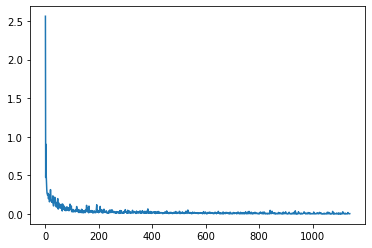

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_dict['loss'])
plt.show()

In [ ]:
model = keras.models.load_model('best_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
f1,y_predict_val = evaluate_model(model, X_list_val, y_val, load_chunks_val = 50)
print('validation f1 accuracy:', f1)

unzipping chunks...
(46, 151, 51, 69, 22)
predict on validation...
validation f1 accuracy: 0.9820343928317005


1.0


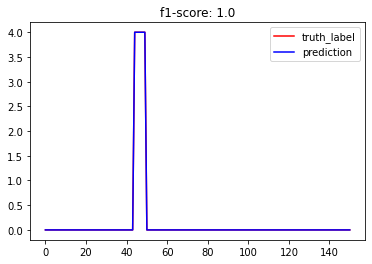

1.0


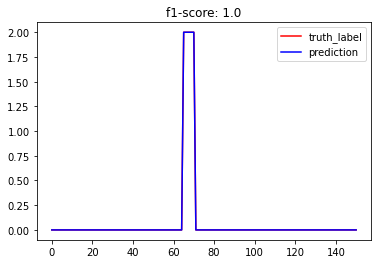

0.9528272414870353


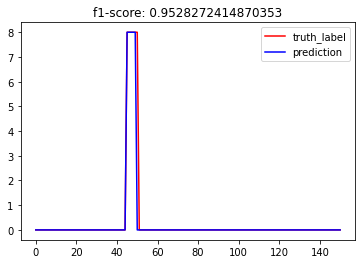

1.0


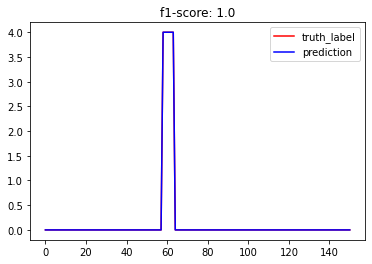

0.9528272414870353


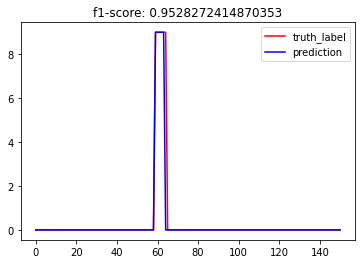

0.9132183908045977


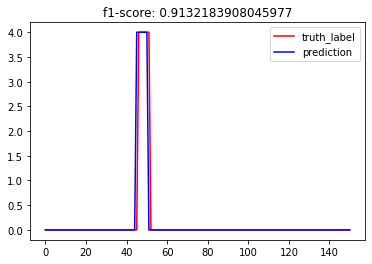

1.0


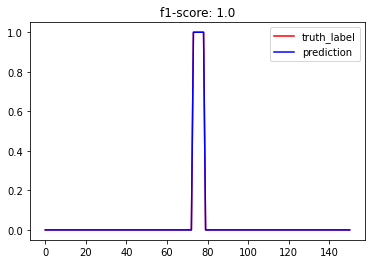

1.0


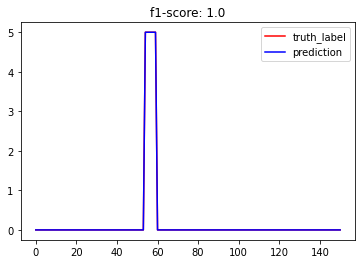

1.0


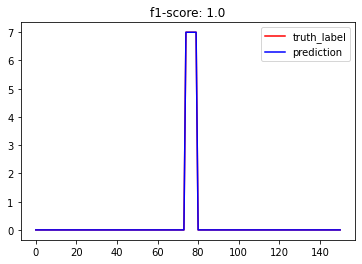

1.0


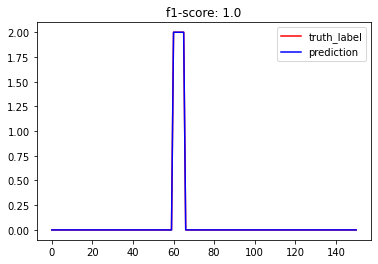

1.0


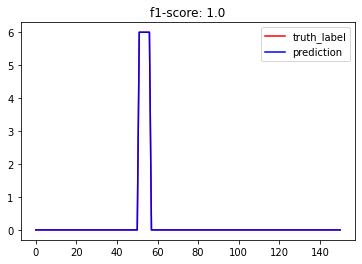

1.0


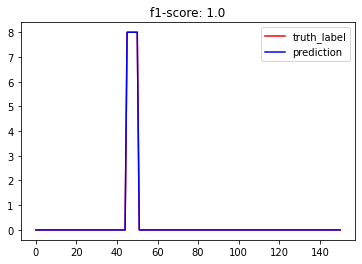

0.9528272414870353


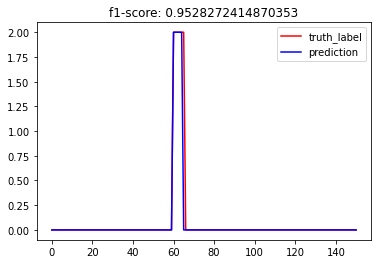

1.0


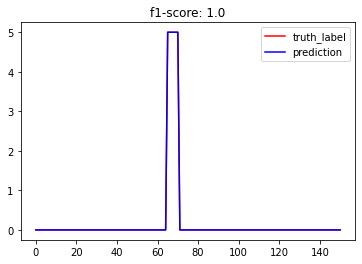

0.9528272414870353


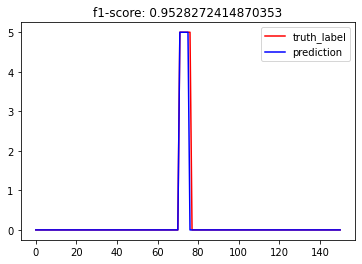

1.0


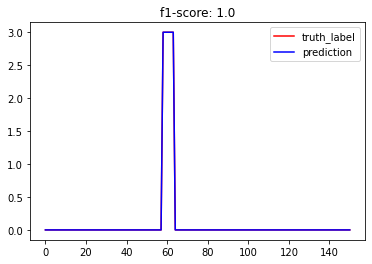

1.0


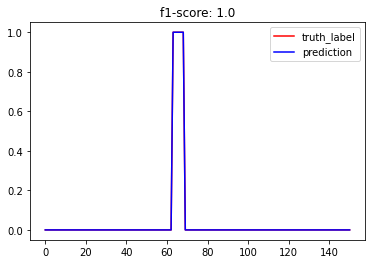

0.9132183908045977


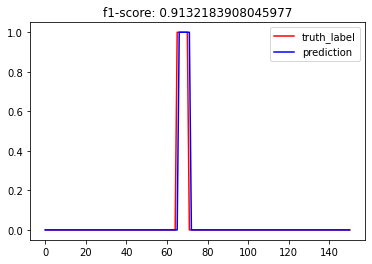

1.0


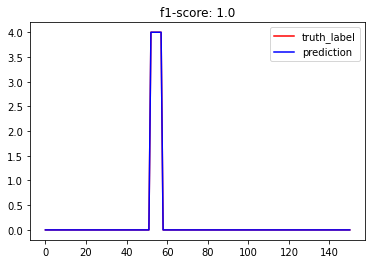

1.0


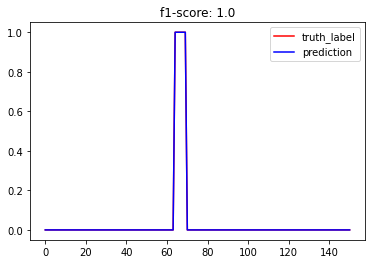

1.0


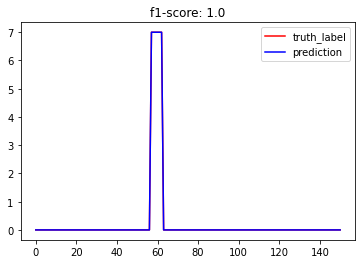

0.9528272414870353


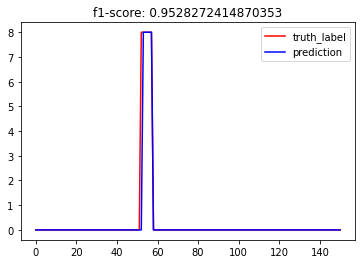

1.0


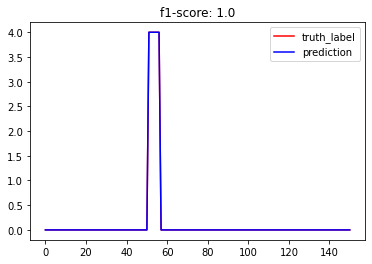

1.0


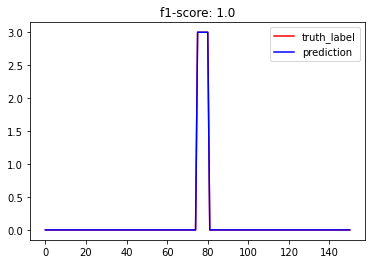

1.0


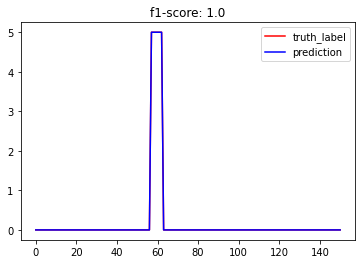

1.0


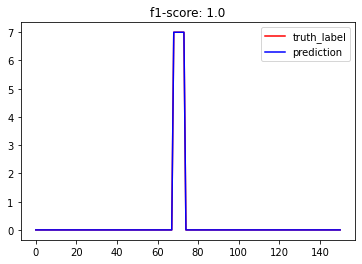

0.9528272414870353


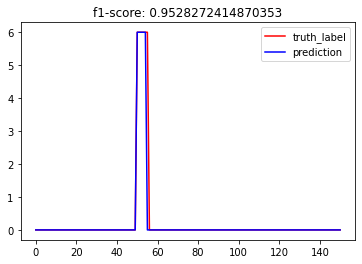

0.9528272414870353


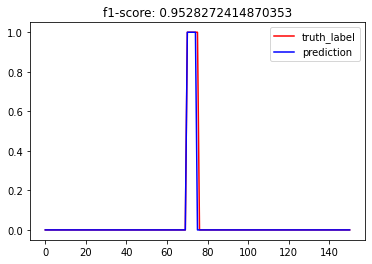

1.0


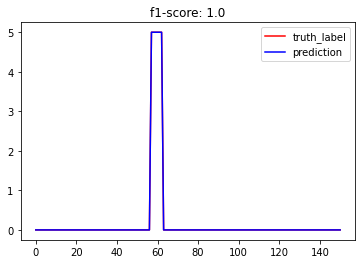

0.9528272414870353


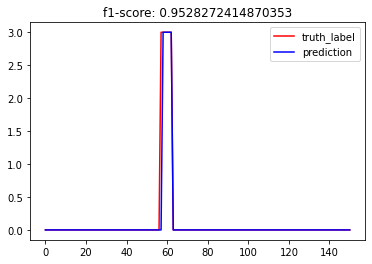

1.0


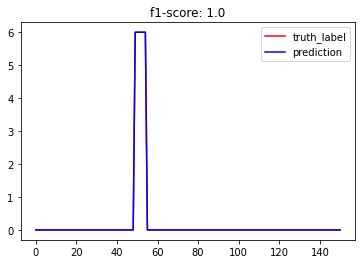

1.0


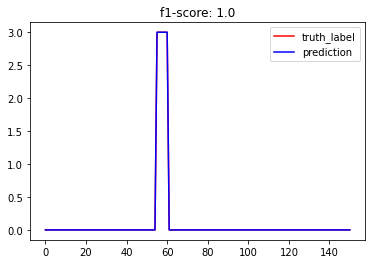

0.8584817244611058


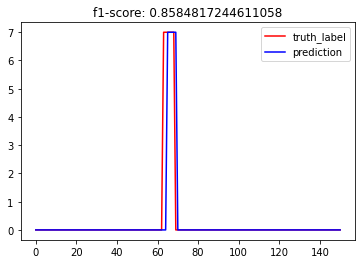

1.0


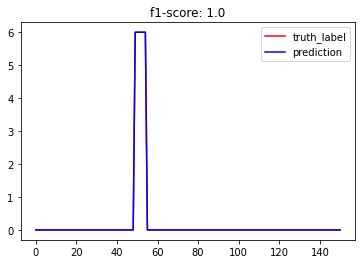

0.9132183908045977


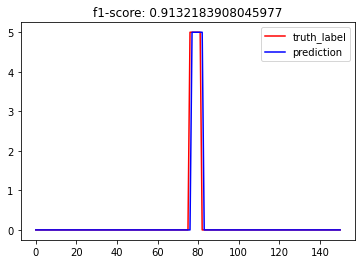

1.0


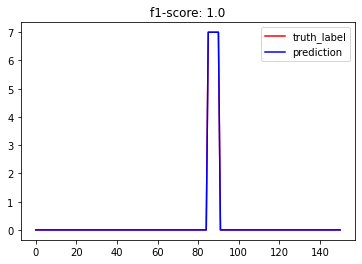

1.0


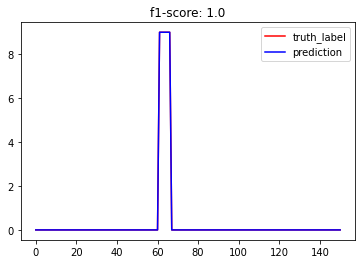

1.0


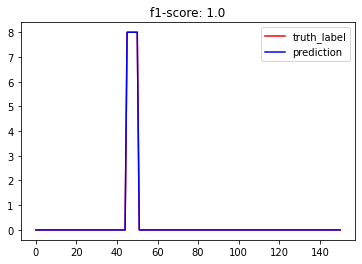

1.0


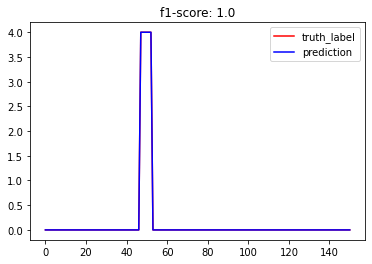

0.9528272414870353


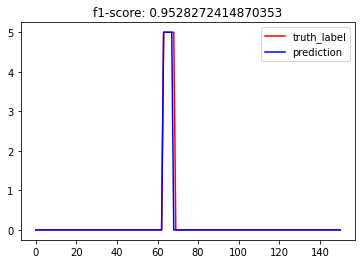

1.0


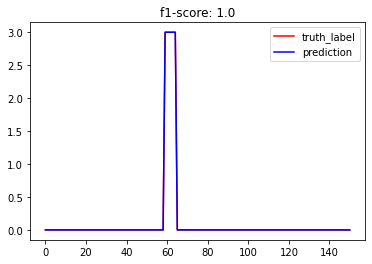

1.0


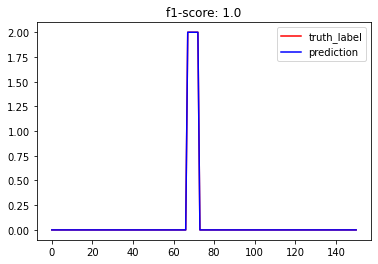

1.0


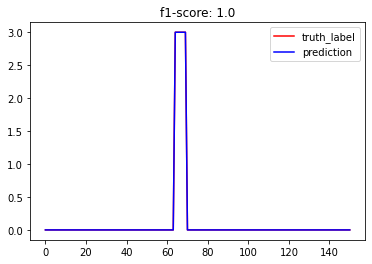

1.0


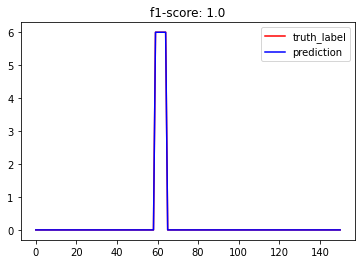

1.0


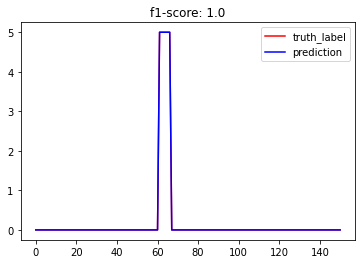

1.0


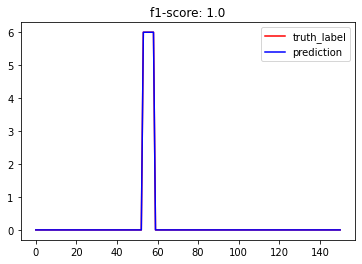

0.9820343928317005


In [ ]:
average_metric = []
for k in range(y_predict_val.shape[0]):
  metric = f1_score(y_val[k,:], y_predict_val[k, :], average ='macro')
  print(metric)
  average_metric.append(metric)
  plt.plot(y_val[k,:], '-r')
  plt.plot(y_predict_val[k, :], '-b')
  plt.legend(['truth_label', 'prediction'])
  plt.title('f1-score: {}'.format(metric))
  plt.show()

average_metric = np.mean(average_metric)
print(average_metric)

In [ ]:
weights_dict = {}
for i, layer in enumerate(model.layers):
  if len(layer.get_weights())==2:
    weights_dict[layer.name] = [np.squeeze(layer.get_weights()[0]), layer.get_weights()[1]]
  else:
    weights_dict[layer.name] = layer.get_weights()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 151, 51, 69, 22)] 0         
_________________________________________________________________
maxpool_1 (MaxPooling3D)     (None, 151, 25, 34, 22)   0         
_________________________________________________________________
dense_layer_1 (Conv3D)       (None, 151, 1, 1, 256)    4787456   
_________________________________________________________________
layer_normalization_3 (Layer (None, 151, 1, 1, 256)    512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 151, 256)          0         
_________________________________________________________________
lstm-1 (LSTM)                (None, 151, 256)          525312    
_________________________________________________________________
layer_normalization_4 (Layer (None, 151, 256)          512 

In [ ]:
def create_inference_model(weights_dict):
  a0_1 = layers.Input(shape=(256,), name='a0_1')
  c0_1 = layers.Input(shape=(256,), name='c0_1')
  a0_2 = layers.Input(shape=(256,), name='a0_2')
  c0_2 = layers.Input(shape=(256,), name='c0_2')
  #---current-input-encoder---------
  input_layer = layers.Input(shape = (51, 69, 22))
  x = layers.MaxPool2D(pool_size=(2, 2), name = 'maxpool_1')(input_layer)

  #fully connected by conv3d op
  t_shape = x.shape.as_list()
  x = layers.Conv2D(256, (t_shape[1], t_shape[2]), activation='relu', name = 'dense_layer_1', weights = weights_dict['dense_layer_1'])(x)
  x = layers.LayerNormalization(weights = weights_dict['layer_normalization_3'])(x)

  t_shape = x.shape.as_list()
  x = layers.Reshape(target_shape= (t_shape[1],t_shape[2]*t_shape[3]))(x)
  x,a_1,c_1 = layers.LSTM(256,return_sequences=True,
                          return_state=True, 
                          weights = weights_dict['lstm-1'],
                          name='lstm-1')(x, initial_state = [a0_1,c0_1])

  x = layers.LayerNormalization(weights = weights_dict['layer_normalization_4'])(x)
  x,a_2,c_2 = layers.LSTM(256,return_sequences=True, 
                          return_state=True, 
                          weights = weights_dict['lstm-2'],
                          name='lstm-2')(x, initial_state = [a0_2,c0_2])

  x = layers.LayerNormalization(weights = weights_dict['layer_normalization_5'])(x)
  x = layers.Dense(num_class,activation='softmax', weights = weights_dict['dense_1'])(x)

  inference_model = models.Model([input_layer,a0_1,a0_2,c0_1,c0_2], [x, a_1, a_2, c_1, c_2])
  return inference_model

In [ ]:
inference_model = create_inference_model(weights_dict)

In [ ]:
inference_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 51, 69, 22)] 0                                            
__________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)        (None, 25, 34, 22)   0           input_31[0][0]                   
__________________________________________________________________________________________________
dense_layer_1 (Conv2D)          (None, 1, 1, 256)    4787456     maxpool_1[0][0]                  
__________________________________________________________________________________________________
layer_normalization_56 (LayerNo (None, 1, 1, 256)    512         dense_layer_1[0][0]              
___________________________________________________________________________________________

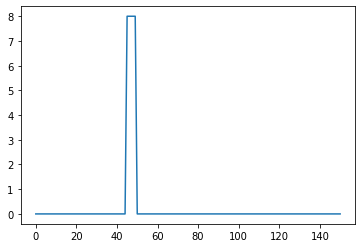

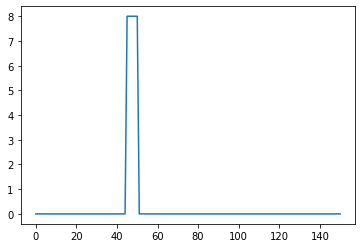

In [ ]:
#sanity check !!!
sample_i = 2
#initial hidden states----------
a_1 = np.zeros((1,256))
a_2 = np.zeros((1,256))
c_1 = np.zeros((1,256))
c_2 = np.zeros((1,256))
outs = []
heatmap_sample = X_list_val[sample_i]['hm']
t = time.time()
for i in range(heatmap_sample.shape[0]):
  x = heatmap_sample[i, :, :, :].reshape(1,51, 69, 22)
  [out, a_1, a_2, c_1, c_2] = inference_model.predict([x, a_1, a_2, c_1, c_2])
  out_cat = np.argmax(out)
  outs.append(out_cat)
delta_t = time.time() - t
plt.plot(outs)
plt.show()
plt.plot(y_val[sample_i,:])
plt.show()

In [ ]:
inference_model.save('inf_model.h5')

97.68522414747518

0

In [ ]:
np.zeros((256,)).shape

(256,)

In [ ]:
with tf.Session() as sess:
  pass

In [ ]:
np.zeros((256,)).shape

(256,)